# Effects of a heuristic k-mer threshold

## Basics

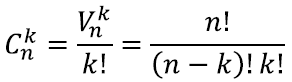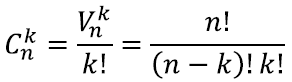

In [214]:
from math import factorial

# how many error combinations for e errors in a sequence of length n
def error_distribution_count(n, e):
    if (n >= e):
        return int(factorial(n) / (factorial(n - e) * factorial(e)))
    else:
        return 0
        
# minimum length of k-mer that does not appear spuriously in this reference
def min_k(ref_len):
    z = 4 #alphabet size
    for k in range(30):
        if (z**k > ref_len):
            return k

def kmer_count(k, n):
    return n - k + 1

def kmer_lemma_threshold(k, n, e):
    return kmer_count(k, n) - (k * e)

In [215]:
error_distribution_count(50, 0)

1

In [216]:
min_k(3e9)

16

In [217]:
kmer_lemma_threshold(16, 50, 5)

-45

## Visualise error distributions

In [218]:
def print_error_dist(n, err_list):
    j = 0
    for i in range(1, n + 1):
        if (j < len(err_list)):
            err_pos = err_list[j]
            if (i != err_pos):
                print("A", end = '')
            else:
                print("x", end = '')
                j += 1
        else:
            print("A", end = '')
    print()

In [219]:
print_error_dist(10, [2, 3, 7])

AxxAAAxAAA


## Find all error distributions

For a given minimum length and number of errors, find all possible error distributions

In [220]:
# for a given number of errors and sequence length
# return a table with e rows
# row i are the starting positions for error e counted from the left
def make_err_pos_list_list(n, e):
    pos_list_list = []
    for first_pos in range(1, e + 1):
        pos_list_list.append(list(range(first_pos, n + 1 - e + first_pos)))
    
    return pos_list_list

In [221]:
#Example for e = 2 and n = 3
#[[1, 2] the first error can be at position 1 or 2 
#[2, 3]] the second error can be at position 2 or 3
make_err_pos_list_list(3, 2)

[[1, 2], [2, 3]]

In [222]:
import itertools

def is_sorted(x, key = lambda x: x): 	
    return all([key(x[i]) <= key(x[i + 1]) for i in range(len(x) - 1)])

def make_err_distributions(n, e):
    pos_list_list = make_err_pos_list_list(n, e)
    combinations = list(itertools.product(*pos_list_list))
    #print(pos_list_list)
    err_list_list = []
    for err_list in combinations:
        if len(err_list) == len(set(err_list)) and is_sorted(err_list):
            err_list_list.append(err_list)

    return err_list_list

In [223]:
print(make_err_distributions(5, 2))
print(len(make_err_distributions(5, 2)) == error_distribution_count(5, 2))

for err_dist in make_err_distributions(5, 2):
    print_error_dist(5, err_dist)

[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
True
xxAAA
xAxAA
xAAxA
xAAAx
AxxAA
AxAxA
AxAAx
AAxxA
AAxAx
AAAxx


In [224]:
min_len = 13
k = 3
e = 3
err_list_list = make_err_distributions(min_len, e)
total_count = len(err_list_list)
print(str(e) + " errors can be configured in " + str(total_count) + " ways on a sequence of length " + str(min_len))

3 errors can be configured in 286 ways on a sequence of length 13


## Exhaustive iteration of error distributions

In [225]:
def all_kmers_destroyed(n, k, err_list):
    if (err_list[0]) > k:
        return False
    for i in range(len(err_list) - 1):
        if (err_list[i+1] - err_list[i]) > k:
            return False
    if (n - err_list[-1]) >= k:
        return False
    return True

In how many error configurations would all shared k-mers be destroyed?

In [226]:
print("total configurations\t" + str(total_count))
print("all destroyed\t", end = '')
    
for threshold in range(0, 1):
    all_destroyed = 0
    for err_list in err_list_list:
        if all_kmers_destroyed(min_len, k, err_list):
            all_destroyed += 1
        else:
            continue
            
print(all_destroyed)
print("Able to capture similarity \t" + str(round(100 - (all_destroyed * 100)/total_count, 2)) + "%")

total configurations	286
all destroyed	0
Able to capture similarity 	100.0%


How many of the error configurations would destroy more than the threshold number of k-mers. That is, in how many cases would the number of errors be in the allowed range but the sequences would not share the threshold number of k-mers.

In [227]:
def count_remaining_kmers(n, k, err_list):
    kmer_count = 0
    if (err_list[0]) > k:
        kmer_count += err_list[0] - k
    for i in range(len(err_list) - 1):
        if (err_list[i+1] - err_list[i]) > k:
            kmer_count += err_list[i+1] - err_list[i] - k
    if (n - err_list[-1] >= k):
        kmer_count += n - err_list[-1] - k + 1
    return kmer_count

In [228]:
print("min length\t" + str(min_len))
print("error count\t" + str(e))
print("k-mer length\t" + str(k))
print("kmer-lemma\t" + str(kmer_lemma_threshold(k, min_len, e)) + "\n")

print("threshold\tFN\tover threshold")
    
for threshold in range(1, 5):
    over_threshold = 0
    for err_list in err_list_list:
        if count_remaining_kmers(min_len, k, err_list) >= threshold:
            over_threshold += 1
        else:
            continue

    print(threshold, end="\t")
    if (over_threshold > 0):
        print(str(round(100 - (over_threshold / total_count) * 100, 2)) + "%\t" + str(over_threshold))
    else:
        print("100%\t0")

min length	13
error count	3
k-mer length	3
kmer-lemma	2

threshold	FN	over threshold
1	0.0%	286
2	0.0%	286
3	3.5%	276
4	17.48%	236


## Dynamic programming approach

Calculate the number of configurations that destroy all k-mers 

In [229]:
table = []
for err in range(e + 1):
    row = []
    for seq_len in range(0, min_len + 1):
        shared_base_count = seq_len - err
        if (k > shared_base_count):
            row.append(error_distribution_count(seq_len, err))
        elif (err == 0):
            row.append(0)
        else:
            row.append(row[-1] + table[-1][seq_len - 1] - table[-1][seq_len - k - 1])
            
    table.append(row)

In [230]:
def get_FN(table, err, min_len):
    return table[err][min_len]

In [231]:
print("min length\t" + str(min_len))
print("error count\t" + str(e))
print("k-mer length\t" + str(k))
print("kmer-lemma\t" + str(kmer_lemma_threshold(k, min_len, e)) + "\n")

print("total configurations\t" + str(total_count))
print("all destroyed\t", str(get_FN(table, e, min_len)))

min length	13
error count	3
k-mer length	3
kmer-lemma	2

total configurations	286
all destroyed	 0


In [232]:
def print_table(table):
    print(end = "\t")
    for seq_len in range(len(table[0])):
        print(seq_len, end = "\t")
    print()
    for err in range(len(table)):
        print(err, end = "\t")
        for seq_len in range(len(table[err])):
            cell = table[err][seq_len]
            print(str(cell), end = "\t")
    
        print("")

print_table(table)

	0	1	2	3	4	5	6	7	8	9	10	11	12	13	
0	1	1	1	0	0	0	0	0	0	0	0	0	0	0	
1	0	1	2	3	2	1	0	0	0	0	0	0	0	0	
2	0	0	1	3	6	7	6	3	1	0	0	0	0	0	
3	0	0	0	1	4	10	16	19	16	10	4	1	0	0	


### Apply threshold

Dynamic programming above: find error distributions that destroy (min_len - k + 1) k-mers \
Goal: find error distributions that destroy at least (min_len - k + 1 - threshold) k-mers

In [311]:
def table_for_threshold(threshold):
    matrix = []
    for t in range(1, threshold + 1):
        table = []
        for err in range(e + 1):
            row = []
            for seq_len in range(0, min_len + 1):
                shared_base_count = seq_len - err
                if (k + t - 1 > shared_base_count): # all error distributions destroy enough k-mers
                    row.append(error_distribution_count(seq_len, err))
                elif (err == 0):
                    row.append(0)
                else:
                    row.append(row[-1] + table[-1][seq_len - 1])

                    # band width is the number of adjacent matrix cells a value depends on
                    band = seq_len - k - t # band width is the number of positions the leftmost error can be in
                    
                    row[-1] -= table[-1][band + t - 1]    
                    for i in range(1, t):
                        row[-1] -= matrix[-i][err - 1][band + t - i - 1]
                        row[-1] += matrix[-i][err - 1][band + t - i]
                        
            table.append(row)
        #print_table(table)
        matrix.append(table)
    return matrix

In [312]:
print("threshold\tFN\tover threshold")
    
for threshold in range(1, 5):
    matrix = table_for_threshold(threshold)
    table = matrix[-1]
    #print_table(table)

    print(threshold, end="\t")
    over_threshold = total_count - table[-1][-1]
    if (over_threshold > 0):
        print(str(round(100 - (over_threshold / total_count) * 100, 2)) + "%\t" + str(over_threshold))
    else:
        print("100%\t0")

threshold	FN	over threshold
1	0.0%	286
2	0.0%	286
3	3.5%	276
4	17.48%	236


## Recursion from Knut

In [239]:
# how many error distributions would destroy all shared k-mers
def f(k, n, e):
    if(e == 0):
        return (1 if (n < k) else 0) # if (n < k) no shared k-mers
        
    sum = 0
    for err_pos in range(1, min(k, n - e) + 1):
        #print(str(n) + "\t" + str(err_pos) + "\t" + str(e - 1))
        sum += f(k, n - err_pos, e - 1)
        
    return sum

def missed_case_rate(k, n, e):
    print("k-mer length\t" + str(k))
    print("min length\t" + str(n))
    print("errors\t" + str(e))
    total_dist_count = error_distribution_count(n, e)
    print("total configurations\t" + str(total_dist_count))
    destroyed_dist_count = f(k, n, e)
    print("all destroyed\t" + str(destroyed_dist_count))
        
    print("\nProbability")
    return round( destroyed_dist_count / total_dist_count, 3)

In [240]:
missed_case_rate(k, min_len, e)

k-mer length	3
min length	13
errors	3
total configurations	286
all destroyed	0

Probability


0.0